In [ ]:
# IMPORTANT:
#   Whenever you start a new colab runtime, use the following code to download
#   the training dataset onto the runtime local storage.
#   This should take ~3-5 mins for the whole dataset.
#   You can then load data from the local storage (/content/data) into your colab
#   notebook using the `h5py` library (see example below).
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="events.csv", repo_type="dataset", local_dir="data")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.h5:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

events.csv:   0%|          | 0.00/782k [00:00<?, ?B/s]

'data/events.csv'

## 1. Data Inspection and Pre-processing

In task 1A, we will predict next 12 frames 'vil' image based on the current 12 frames 'vil' image. We first pick an event to observe data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import h5py
import IPython
import PIL
import matplotlib.pyplot as plt
import os
import io
# this DataFrame contains all of the event meta data
df = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
# Take all event id as a list
Event_List = df.id.unique().tolist()
# this function loads all of the image arrays for a given id
def load_event(id):
    "Load event"
    with h5py.File(f'data/train.h5','r') as f:
        event = {img_type: f[id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil', 'lght']}
    return event

event = load_event("S778114")
for img_type in event:
    print(f"{img_type}: {event[img_type].shape} ({event[img_type].dtype})")

# load event 0
Event0 = load_event(Event_List[0])
Vil0 = Event0['vil']

vis: (384, 384, 36) (int16)
ir069: (192, 192, 36) (int16)
ir107: (192, 192, 36) (int16)
vil: (384, 384, 36) (uint8)
lght: (38777, 5) (float32)


This shows, vil data is a (384,384,36) shape tensor, which means it contains 36 continous frames of the vil image, and next, a box-plot is ploted for showing its data range. And we can see, all of them are in the interval $[0,255]$. A certain data range is beneficial for training neural networks.

<ipython-input-7-57781075fece>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(Vil0.reshape(384*384,36), showfliers=False, whis=[0,100],  labels=range(36))


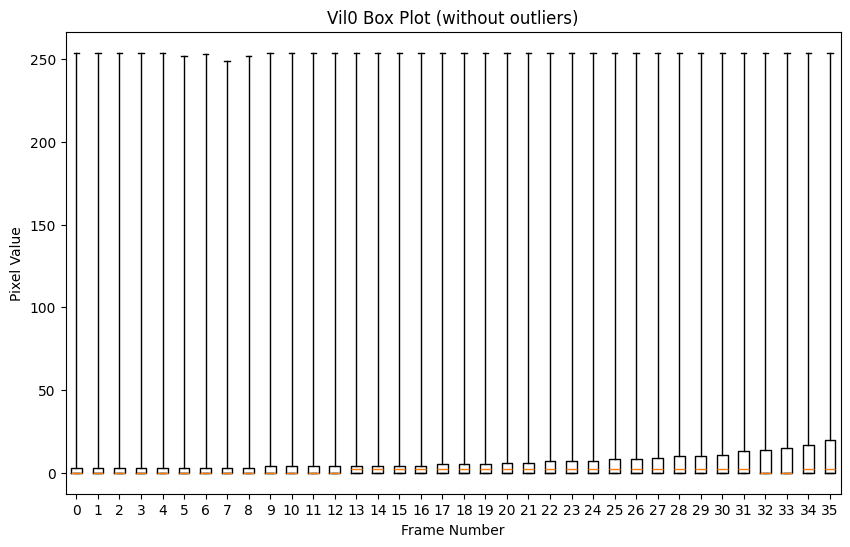

In [ ]:
# prompt: 将Vil0画成箱图，但不要标注outlier,直接用最大最小值

import matplotlib.pyplot as plt

# Calculate quartiles, min, and max
q1 = Vil0.min(axis=(0, 1))
q3 = Vil0.max(axis=(0, 1))
iqr = q3 - q1
lower_bound = q1
upper_bound = q3

# Create the boxplot without outliers
plt.figure(figsize=(10, 6))
plt.boxplot(Vil0.reshape(384*384,36), showfliers=False, whis=[0,100],  labels=range(36))
plt.xlabel("Frame Number")
plt.ylabel("Pixel Value")
plt.title("Vil0 Box Plot (without outliers)")

plt.show()

Now we know, for each event(storm), there are 36 images, considering our task is that use 12 frames to predict next 12 frames, we need to split the input(X) from shape $(384,384,36)$ into $(384,384,12,num4)$, and split the label(Y) from shape $(384,384,36)$ into $(384,384,num3,num4)$. The $num3$ and $num4$ depend on the model. We first consider 'Rolling Windows Predict' model. it means, the first 12 frames will be applied to predict the 13th frame and then, the frames 2 - 13 will be used to predict 14th frame, and repeat this process until all 12 future frames, 13 - 24, are predicted, like the figure shows. In this situations, $num3$ is $1$ and $num4$ is $36 - 12 = 24$ in each events. Hence the total dataset with $800$ storms will be split into the inputs(X) with shape $(384,384,12,19200)$ and labels(Y) with shape $(384,384,1,19200)$. It's so large that the memory will be out. So we only use a little part of the dataset for training, and considering Mini-batch and Event-wise Training. The next, thw split function will be implemented.

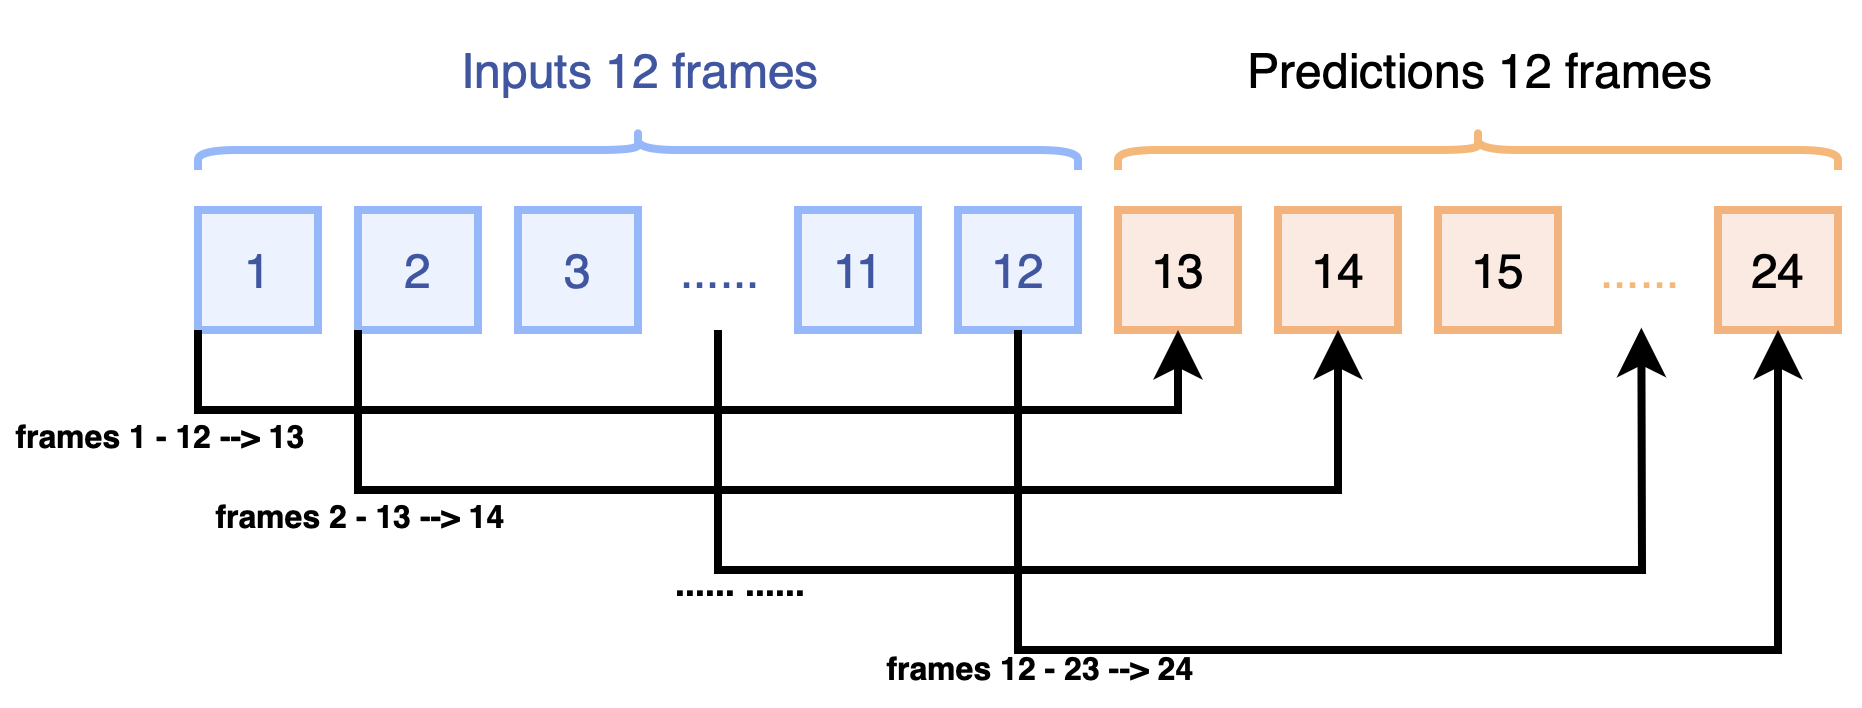

In [ ]:
# this function can split data
def split_data(data, context_length=12):
    height, width, sequence_length = data.shape
    num_samples = sequence_length - context_length
    X = np.zeros((height, width, context_length, num_samples), dtype=data.dtype)
    Y = np.zeros((height, width, num_samples), dtype=data.dtype)
    # using rolling windows in the whole sequence
    for i in range(num_samples):
        # pick X (input) and Y(label) data
        X[:, :, :, i] = data[:, :, i : i + context_length]
        Y[:, :, i] = data[:, :, i + context_length]
    return X[:,:,:,:sequence_length - context_length], Y[:,:,:sequence_length - context_length]

In [ ]:
# An example
id = Event_List[100]
event = load_event(id)
Vil = event["vil"]
X_example, Y_example = split_data(Vil)
Y_example = np.expand_dims(Y_example, axis=2)
print('The shape of X_example is', X_example.shape)
print('The shape of Y_example is', Y_example.shape)

The shape of X_example is (384, 384, 12, 24)
The shape of Y_example is (384, 384, 1, 24)


And we can see the shape of Input and Label are proper now. Then we will split the data set into train set and test set. Due to the huge size of this dataset, memory out error always occur when the training set is too large. Therefore, we will only randomly select a small training set. We will first consider the case of selecting 100 training sets and 10 test sets, and we will focus on the set size analysis in the following text.

In [ ]:
import random
random.seed(42)
RD_List = random.sample(Event_List, 110)
Train_List = RD_List[0:-10]
Test_List = RD_List[-11:-1]
print('The train set size is', len(Train_List))
print('The test set size is', len(Test_List))


The train set size is 100
The test set size is 10


In order to further save computing resources and facilitate subsequent data calls, we have pre processed all events using split_function for their Input and Label pairs, and saved them in two separate folders '/content/drive/My Drive/Data/X' and '/content/drive/My Drive/Data/Y'. This allow us use only a small GPU memory to quickly complete the training of the CNNs neural network.

In [ ]:
j = 0
for i in Event_List:
    j = j+1
    event = load_event(i)
    Vil = event["vil"]
    Xi, Yi = split_data(Vil)
    Yi = np.expand_dims(Yi, axis=2)
    file_pathX = os.path.join('/content/drive/My Drive/Data/X', f'{i}.h5')
    file_pathY = os.path.join('/content/drive/My Drive/Data/Y', f'{i}.h5')
    with h5py.File(file_pathX, 'w') as hf:
        hf.create_dataset('data', data=Xi, compression='gzip')
    with h5py.File(file_pathY, 'w') as hf:
        hf.create_dataset('data', data=Yi, compression='gzip')

## 2. Architectures
Now let's build the CNNs network. Continuely

This first class $LazyVILDataset(Dataset)$ defines a dataset for training and testing the neural network. It implements lazy loading, meaning data is loaded from disk only when needed instead of being preloaded into memory. This is efficient when working with large datasets.

And then, the next class $VILPredictor(nn.Module)$ defines a CNN-based neural network for processing volumetric input data.
The architecture consists of 3D convolutional layers followed by 2D convolutional layers. 3D convolutional layer extracts spatial and temporal features from input, using 1 input channel and outputs 16 channels. The kernel size (3,3,3) ensures local feature extraction. A 2D convolution layer to further extract features from flattened depth slices. The final output layer that reduces feature maps to a single prediction channel. According to the Hints in Slides, we use $MAE$ as the loss function.





In [ ]:
import os
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Dataset definition with lazy loading
class LazyVILDataset(Dataset):
    def __init__(self, file_list, x_dir, y_dir):

        self.file_list = file_list
        self.x_dir = x_dir
        self.y_dir = y_dir

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]

        # loading X and Y
        x_path = os.path.join(self.x_dir, f"{file_name}.h5")
        y_path = os.path.join(self.y_dir, f"{file_name}.h5")

        with h5py.File(x_path, 'r') as x_file, h5py.File(y_path, 'r') as y_file:
            X = torch.from_numpy(x_file['data'][:]).float()  # Shape: (384, 384, 12, 24)
            Y = torch.from_numpy(y_file['data'][:]).float()  # Shape: (384, 384, 1, 24)

            # Reshape X and Y to match the model’s input format
            # X (num_samples=24, channels=1, depth=12, height=384, width=384)
            X = X.permute(3, 2, 0, 1).unsqueeze(1)  # (24, 1, 12, 384, 384)
            # Y (num_samples=24, channels=1, height=384, width=384)
            Y = Y.permute(3, 2, 0, 1)               # (24, 1, 384, 384)

        return X, Y

# Model definition
class VILPredictor(nn.Module):
    def __init__(self):
        super(VILPredictor, self).__init__()
        # chanels numbers
        self.conv3d = nn.Conv3d(1, 16, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.relu = nn.ReLU()
        self.conv2d_1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2d_2 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv3d(x)
        x = self.relu(x)
        x = torch.mean(x, dim=2)
        x = self.conv2d_1(x)
        x = self.relu(x)
        x = self.conv2d_2(x)
        return x

# Training function
def train_model(model, dataloader, num_epochs=100, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.L1Loss()  # MAE
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        # tqdm - dataloader to show process
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")

        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

            # release memory
            del inputs, targets, outputs, loss
            torch.cuda.empty_cache()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}")


# Testing function
def test_model(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # Shape: (batch_size, 1, 384, 384)
            predictions.append(outputs.cpu().numpy())

    return np.concatenate(predictions, axis=0)  # Shape: (num_samples, 1, 384, 384)

def custom_collate_fn(batch):
    """
    Custom collate function to flatten dataset into individual samples.

    Args:
        batch: A list of tuples [(X, Y)] where X and Y are (num_samples, channels, ...).

    Returns:
        Flattened tensors for X and Y.
    """
    X, Y = batch[0]  # Each batch contains a single tuple (X, Y)
    num_samples = X.shape[0]  # Flatten along the sample dimension

    # Flatten X and Y into individual samples
    X = X.view(-1, *X.shape[1:])  # (num_samples, 1, 12, 384, 384)
    Y = Y.view(-1, *Y.shape[1:])  # (num_samples, 1, 384, 384)

    return X, Y


## 3. Train, Test and Evaluation
Based on above architectures, the model will be trained on the train test

In [ ]:
# Main function
if __name__ == "__main__":
    # File paths and event list
    x_dir = '/content/drive/My Drive/Data/X'
    y_dir = '/content/drive/My Drive/Data/Y'

    # Initialize
    print("Initializing dataset and dataloader...")
    train_dataset = LazyVILDataset(Train_List, x_dir, y_dir)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

    # Initialize model
    model = VILPredictor()

    # Train model and save
    print("Training model...")
    train_model(model, train_loader, num_epochs=30, lr=0.001)
    torch.save(model.state_dict(), '/content/drive/My Drive/Model/Task_1A_1.pth')
    print("Model saved")

Initializing dataset and dataloader...
Training model...


Epoch 1/30: 100%|██████████| 100/100 [03:15<00:00,  1.95s/batch, loss=11.9347]


Epoch [1/30], Loss: 13.4616


Epoch 2/30: 100%|██████████| 100/100 [01:03<00:00,  1.57batch/s, loss=8.4230]


Epoch [2/30], Loss: 11.4820


Epoch 3/30: 100%|██████████| 100/100 [01:03<00:00,  1.57batch/s, loss=11.1037]


Epoch [3/30], Loss: 10.2005


Epoch 4/30: 100%|██████████| 100/100 [01:03<00:00,  1.56batch/s, loss=11.9980]


Epoch [4/30], Loss: 8.6188


Epoch 5/30: 100%|██████████| 100/100 [01:03<00:00,  1.56batch/s, loss=8.5224]


Epoch [5/30], Loss: 7.4808


Epoch 6/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=5.3089]


Epoch [6/30], Loss: 7.5739


Epoch 7/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=2.5628]


Epoch [7/30], Loss: 7.2987


Epoch 8/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=11.0548]


Epoch [8/30], Loss: 6.5396


Epoch 9/30: 100%|██████████| 100/100 [01:03<00:00,  1.57batch/s, loss=8.8734]


Epoch [9/30], Loss: 6.3965


Epoch 10/30: 100%|██████████| 100/100 [01:03<00:00,  1.56batch/s, loss=6.9569]


Epoch [10/30], Loss: 6.4008


Epoch 11/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=3.8816]


Epoch [11/30], Loss: 6.0272


Epoch 12/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=10.0186]


Epoch [12/30], Loss: 6.0414


Epoch 13/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=0.4669]


Epoch [13/30], Loss: 6.0992


Epoch 14/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=13.8508]


Epoch [14/30], Loss: 6.0150


Epoch 15/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=7.0413]


Epoch [15/30], Loss: 5.7440


Epoch 16/30: 100%|██████████| 100/100 [01:03<00:00,  1.57batch/s, loss=0.2331]


Epoch [16/30], Loss: 5.7257


Epoch 17/30: 100%|██████████| 100/100 [01:03<00:00,  1.57batch/s, loss=10.1740]


Epoch [17/30], Loss: 5.7505


Epoch 18/30: 100%|██████████| 100/100 [01:03<00:00,  1.56batch/s, loss=6.3295]


Epoch [18/30], Loss: 5.6615


Epoch 19/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=0.5976]


Epoch [19/30], Loss: 5.6069


Epoch 20/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=6.8600]


Epoch [20/30], Loss: 5.5752


Epoch 21/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=6.6973]


Epoch [21/30], Loss: 5.4405


Epoch 22/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=5.5021]


Epoch [22/30], Loss: 5.4664


Epoch 23/30: 100%|██████████| 100/100 [01:03<00:00,  1.56batch/s, loss=4.8454]


Epoch [23/30], Loss: 5.4065


Epoch 24/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=1.1662]


Epoch [24/30], Loss: 5.3865


Epoch 25/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=5.4658]


Epoch [25/30], Loss: 5.3763


Epoch 26/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=2.7077]


Epoch [26/30], Loss: 5.4389


Epoch 27/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=4.8957]


Epoch [27/30], Loss: 5.3958


Epoch 28/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=3.4259]


Epoch [28/30], Loss: 5.2691


Epoch 29/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=2.1710]


Epoch [29/30], Loss: 5.2529


Epoch 30/30: 100%|██████████| 100/100 [01:04<00:00,  1.56batch/s, loss=10.4789]

Epoch [30/30], Loss: 5.2971
Model saved


To visualize the result, the $visualize_-predictions(test_-loader, predictions)$ is implemented. It outputs 3 columns of image. They are Truth image, Predicted image and Error hotmap. And then the $multi_-step_-prediction(model, initial_-rames, num_-predictions)$ perform multi-step predictions using a rolling window approach.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(test_loader, predictions):
    """
    Visualizes the predictions alongside the ground truth and computes the error.

    Args:
        test_loader: Numpy array of the ground truth frames (384, 384, num_samples).
        predictions: Numpy array of the predicted frames (384, 384, num_samples).
    """
    # check predictions and test_loader dimensions
    if predictions.shape != test_loader.shape:
        raise ValueError("Predictions and test_loader dimensions do not match.")

    # Initialize
    num_frames = predictions.shape[2]
    fig, axes = plt.subplots(num_frames, 3, figsize=(15, 5 * num_frames))

    if num_frames == 1:
        axes = np.expand_dims(axes, axis=0)

    # All frames for loop
    for i in range(num_frames):
        # take Ground Truth and Predictions
        true_frame = test_loader[..., i].squeeze()  # Ground Truth
        pred_frame = predictions[..., i].squeeze()  # Prediction
        error_frame = np.abs(true_frame - pred_frame)  # 计算绝对误差

        # Plot Ground Truth
        axes[i, 0].imshow(true_frame, cmap='turbo')
        axes[i, 0].set_title(f"Ground Truth Frame {i + 1}")
        axes[i, 0].axis('off')

        # Plot Prediction
        axes[i, 1].imshow(pred_frame, cmap='turbo')
        axes[i, 1].set_title(f"Predicted Frame {i + 1}")
        axes[i, 1].axis('off')

        # Plot Error Frame
        axes[i, 2].imshow(error_frame, cmap='hot')
        axes[i, 2].set_title(f"Error Frame {i + 1} (Abs Diff)")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Rolling prediction 12 steps
def multi_step_prediction(model, initial_frames, num_predictions):
    """
    Perform multi-step predictions using a sliding window approach.

    Args:
        model (nn.Module): The trained model.
        initial_frames (torch.Tensor): The initial 12 frames (shape: 1, 1, 12, 384, 384).
        num_predictions (int): Number of future frames to predict (e.g., 13-24 = 12 frames).

    Returns:
        np.ndarray: Predicted frames (shape: 384, 384, 1, num_predictions).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set model to evaluation mode

    # Ensure initial_frames is on the correct device
    initial_frames = initial_frames.to(device)

    # List to store predictions
    predicted_frames = []

    # Start the sliding window prediction
    current_input = initial_frames.clone()  # Clone the initial input to avoid modification
    for _ in range(num_predictions):
        with torch.no_grad():
            # Perform prediction for the next frame
            next_frame = model(current_input)  # Shape: (1, 1, 384, 384)

        # Append the predicted frame to the result list
        predicted_frames.append(next_frame.squeeze().cpu().numpy())  # Convert to NumPy array

        # Update the input for the next prediction
        # Remove the oldest frame and append the new predicted frame
        current_input = torch.cat([current_input[:, :, 1:, :, :], next_frame.unsqueeze(2)], dim=2)

    # Stack predictions into a single array: (384, 384, 1, num_predictions)
    predicted_frames = np.stack(predicted_frames, axis=-1)

    return predicted_frames


Finally, Let's test and evaluate the model, considering for each event, there will be $12*3 = 48$ images as output (Truth, Predictions and Error map). It need a large space, so for the visualization comparasion, we only pick the first event in the test set.

In [ ]:
# Test with visualization comparation
print("Testing model...")
test_dataset = LazyVILDataset(Test_List[:1], x_dir, y_dir)  # Example: first 1 events as test set
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)

for inputs, truths in test_loader:
    initial_frames = inputs
    initial_frames = initial_frames[0:1]# Shape: (1, 1, 12, 384, 384)
    Y_frames = truths
    Ytest = Y_frames[0:12].squeeze(1).permute(1, 2, 0)
    break

# rolling prediction
num_predictions = 12
predicted_frames = multi_step_prediction(model, initial_frames, num_predictions)

# visualization
print("Visualizing multi-step predictions...")
visualize_predictions(Ytest, predicted_frames)



It can be seen that the prediction results of the first few frames are quite good, almost identical to the real picture. However, as time goes on, the error of the later frames becomes larger and larger. This is because the error will continuely accumulate in rolling prediction。 Next, the prediction performance will be quantitatively evaluated using MAE and compared with the baseline. For the baseline, we consider use the 12th frames, repeat 12 times as the baseline predictions. Now let's define a function, it cauculate the baseline and predictions, and further returns their MAE series (12 frames), for each storm's first 12 frames

In [ ]:
def test_storm(id):
    test_dataset = LazyVILDataset(Test_List[:id], x_dir, y_dir)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)

    fr = 1
    for inputs, truths in test_loader:
        initial_frames = inputs
        initial_frames = initial_frames[0:1]# Shape: (1, 1, 12, 384, 384)
        if fr == 1: # repeat 12th frames 12 times as the base line
            base_line = initial_frames[:,:,-1,:,:].squeeze()
            base_line = base_line.unsqueeze(-1).repeat(1, 1, 12)
        Y_frames = truths
        Ytest = Y_frames[0:12].squeeze(1).permute(1, 2, 0)
        fr = fr + 1
        break

    num_predictions = 12
    predicted_frames = multi_step_prediction(model, initial_frames, num_predictions)

    baselineMAE = torch.mean(torch.abs(Ytest - base_line), dim=(0, 1))
    predictionMAE = torch.mean(torch.abs(Ytest - predicted_frames), dim=(0, 1))

    return baselineMAE, predictionMAE


Now plot all the storm's MAE curve in test set vs the base line

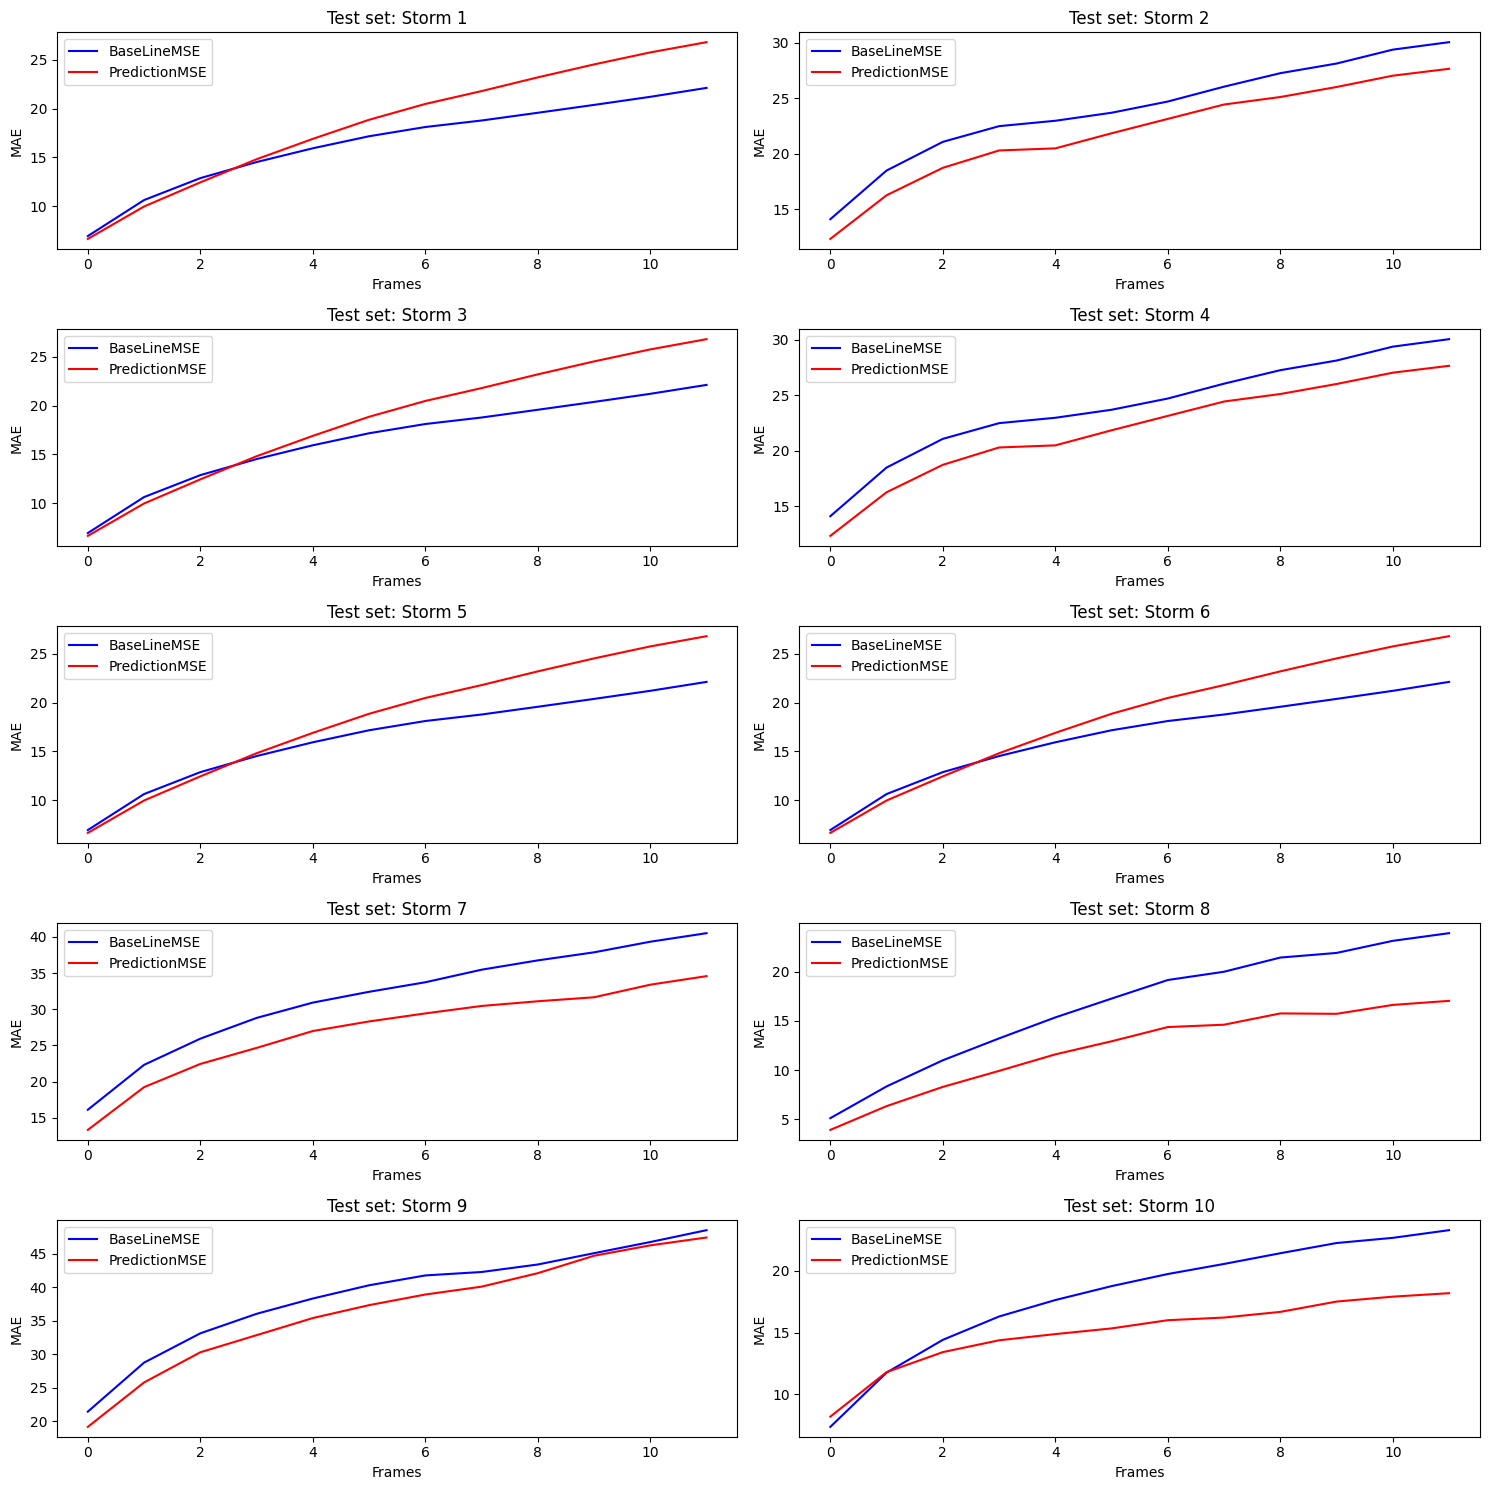

In [ ]:
import matplotlib.pyplot as plt
import torch

# 创建一个5x2的子图
fig, axs = plt.subplots(5, 2, figsize=(15, 15))

# 循环10次，每次生成两个张量并绘制折线图
id = 1
blMAEsum = np.zeros([1,12])
pdMAEsum = np.zeros([1,12])
for i in range(5):
    for j in range(2):
        blMAE,pdMAE = test_storm(id)
        blMAEsum = blMAEsum + np.array(blMAE)
        pdMAEsum = pdMAEsum + np.array(pdMAE)
        axs[i, j].plot(blMAE, color='blue', label='BaseLineMSE')
        axs[i, j].plot(pdMAE, color='red', label='PredictionMSE')
        axs[i, j].legend()
        axs[i, j].set_title(f'Test set: Storm {id}')
        axs[i, j].set_xlabel('Frames')
        axs[i, j].set_ylabel('MAE')
        id = id + 1

blMAEmean = blMAEsum/12
pdMAEmean = pdMAEsum/12
plt.tight_layout()
plt.show()


array([[ 8.84700294, 12.56155785, 14.84578554, 16.45199855, 17.65713183,
        18.72884591, 19.68279791, 20.45242723, 21.31076622, 22.06414636,
        22.94607719, 23.72393862]])

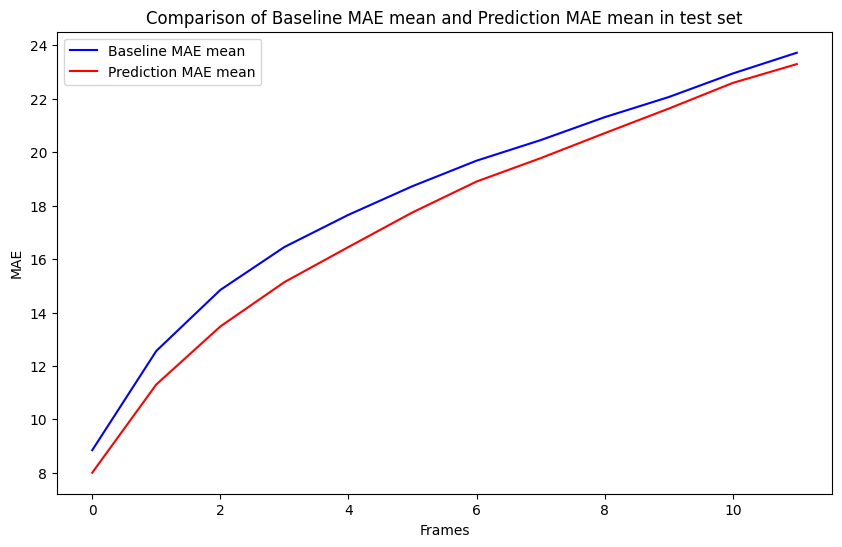

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(blMAEmean[0], color='blue', label='Baseline MAE mean')
plt.plot(pdMAEmean[0], color='red', label='Prediction MAE mean')
plt.xlabel('Frames')
plt.ylabel('MAE')
plt.title('Comparison of Baseline MAE mean and Prediction MAE mean in test set')
plt.legend()
plt.show()

As can be seen, the mean MAE of our model's predicted results is smaller than that of BaseLine on the entire test set, and this is also true in most stories, especially in the first three frames. This supports the excellent prediction results of our model. In the later frames, our model's predictions began to approach the baseline, and in a few Storms, the MAE of the prediction exceeded the baseline. Overall, both the baseline and the predicted results of our model show an increase in MAE over time, which is consistent with our intuition during the visualization analysis mentioned earlier and is also one of the issues that need to be addressed in future work

## 4. Data Processing and Dataloader Optimization

### Previous Approach

Previously, during data reading, a pre-processing `split_data` operation was performed. The processed and segmented data blocks were saved on Google Drive for later use. This approach effectively avoided RAM space shortages. However, pre-processing data was cumbersome and required processing the entire dataset in advance, which could lead to storage space wastage. Additionally, frequent disk read and write operations could impact the overall system performance.

### Transition to On-the-Fly Data Processing

To address the drawbacks of the previous approach, we considered embedding the data segmentation operation within the `Dataset`. The specific advantages of this method include:

- **On-Demand Loading**:
  - **No Need for Full Dataset Storage**: There's no requirement to store the entire pre-processed dataset on disk or in memory.
  - **Reduced Storage Requirements**: Data is loaded as needed during the training process, minimizing storage usage.
  
- **Handling Large-Scale Data**:
  - **Scalability**: Suitable for large datasets that cannot be entirely loaded into memory, enhancing the model's scalability.
  
- **Improved Training Efficiency**:
  - **Faster Initialization**: Eliminates the need to spend significant time on one-time pre-processing, allowing the training process to start more quickly.
  - **Parallel Processing**: Data processing can occur in parallel with model training, fully utilizing computational resources and reducing overall training time.
  
- **Enhanced System Maintainability**:
  - **Flexibility**: Facilitates easy modification of data processing and augmentation strategies without the need to re-preprocess the entire dataset.

### Challenges Encountered

During the initial attempt to embed data segmentation and processing operations within the `Dataset`, the system crashed due to complete RAM exhaustion. This issue highlighted the need for further optimization to ensure efficient memory usage.

### Modifications and Optimizations

To overcome the memory issues and improve performance, we made the following modifications and optimizations to the `LazyVILDataset` and `DataLoader`:

#### 1. **LazyVILDataset Enhancements**

- **Index Mapping (`self.index_map`)**:
  - Allows the dataset to efficiently retrieve any sample through a global index without pre-loading all data into memory.
  
- **On-Demand Loading in `__getitem__`**:
  - Ensures that only the necessary data is loaded into RAM each time a sample is accessed, significantly reducing memory usage.

#### 2. **DataLoader Optimizations**

- **Increased `num_workers`**:
  - **Setting**: `num_workers=4`
  - **Benefit**: Increases the number of worker threads to parallelize the `__getitem__` calls, thereby accelerating data loading speed.
  
- **Enabled `pin_memory`**:
  - **Setting**: `pin_memory=True`
  - **Benefit**: Improves the speed of data transfer from CPU to GPU by enabling pinned (page-locked) memory.

  **By optimizing the dataset and dataloader, the model can train on the entire dataset (800 storms) even when RAM is limited, greatly enhancing the flexibility of model training.**

In [ ]:
class LazyVILDataset(Dataset):
    def __init__(self, h5_path, context_length=12, selected_groups=None, normalize=True):
        """
        Initializes the LazyVILDataset.

        Args:
            h5_path (str): Path to the train.h5 file.
            context_length (int): Number of time steps for input X.
            selected_groups (list or None): List of group names to include. If None, includes all groups containing 'vil' dataset.
            normalize (bool): Whether to apply normalization to the data.
        """
        self.h5_path = h5_path
        self.context_length = context_length
        self.selected_groups = selected_groups
        self.index_map = []  # List of tuples (group_name, sample_idx_within_group)
        self.normalize = normalize

        # Build the index mapping
        with h5py.File(self.h5_path, 'r') as hf:
            if self.selected_groups is not None:
                groups = self.selected_groups
            else:
                # Include all top-level groups that contain 'vil' dataset
                groups = [key for key in hf.keys() if 'vil' in hf[key]]

            for group in groups:
                vil_path = f"{group}/vil"
                if vil_path in hf:
                    vil_data = hf[vil_path]
                    height, width, sequence_length = vil_data.shape
                    num_samples = sequence_length - self.context_length
                    for sample_idx in range(num_samples):
                        self.index_map.append((group, sample_idx))
                else:
                    print(f"Warning: '{vil_path}' does not exist in the HDF5 file.")

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        """
        Retrieves the sample at the specified index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: Tuple containing:
                - X (torch.Tensor): Input tensor of shape [1, Depth, Height, Width].
                - Y (torch.Tensor): Target tensor of shape [1, Height, Width].
                - X_mean (float): Mean of the input tensor.
                - X_std (float): Standard deviation of the input tensor.
                - Y_mean (float): Mean of the target tensor.
                - Y_std (float): Standard deviation of the target tensor.
        """
        group, sample_idx = self.index_map[idx]
        with h5py.File(self.h5_path, 'r') as hf:
            vil_path = f"{group}/vil"
            vil_data = hf[vil_path]
            X_np = vil_data[:, :, sample_idx : sample_idx + self.context_length]  # Shape: [H, W, D=12]
            Y_np = vil_data[:, :, sample_idx + self.context_length]  # Shape: [H, W]

        # Transpose axes to get [D, H, W]
        X_np = np.transpose(X_np, (2, 0, 1))  # Shape: [D=12, H, W]

        # Convert to tensor and add channel dimension
        X = torch.from_numpy(X_np).float().unsqueeze(0)  # Shape: [C=1, D=12, H, W]
        Y = torch.from_numpy(Y_np).float().unsqueeze(0)  # Shape: [C=1, H, W]

        if self.normalize:
            # Normalize X and Y to have zero mean and unit variance
            X_mean = X.mean()
            X_std = X.std()
            Y_mean = Y.mean()
            Y_std = Y.std()

            # Prevent division by zero
            if X_std == 0:
                X_std = 1
            if Y_std == 0:
                Y_std = 1

            X = (X - X_mean) / X_std
            Y = (Y - Y_mean) / Y_std
        else:
            # If not normalizing, set mean and std to None
            X_mean = None
            X_std = None
            Y_mean = None
            Y_std = None

        return X, Y, X_mean, X_std, Y_mean, Y_std

## 5. Model Tuning

Upon observing the predicted images, it was found that the generated images did not exhibit a clear temporal trend, indicating that the model might not have adequately captured the time series information. Therefore, an attempt was made to make the current network more complex to help the model understand the time series information better.

Given that the training data is input to the model in a manner similar to sliding window operations, this input method provides the network with time series information. Therefore, the complexity of the CNN architecture was increased (by adding an additional layer with 64 convolutional kernels) to help the model capture complex image and time series information, thereby improving model performance. **(But the model performance is wrong, which will be mentioned later)**

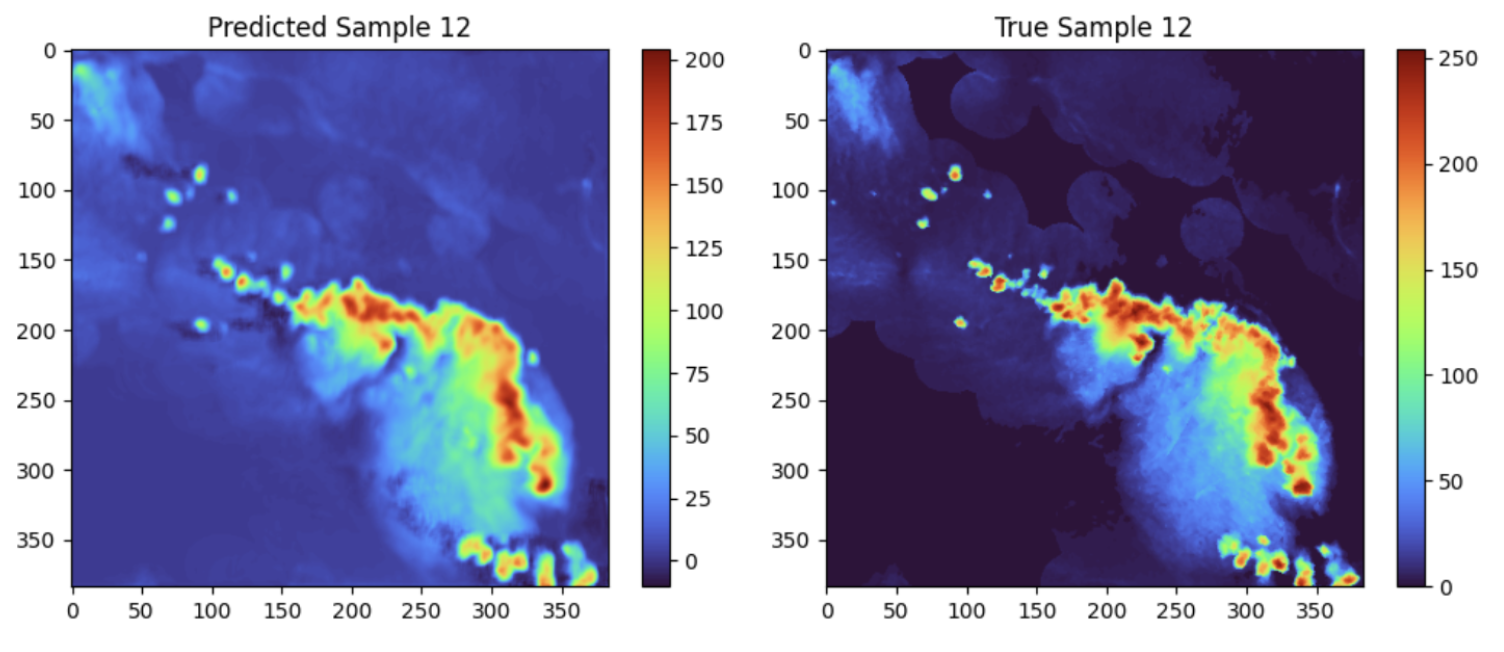

Upon observing the test set images, it was found that the optimized model can capture time series information. The generated predicted images are generally consistent with the real images in terms of trends and features, demonstrating excellent model performance.

However, although the predicted data are very similar to the true values in terms of trends and relative magnitudes, the overall numerical range is generally smaller. In some cases, the true values can reach peaks of up to 250, while the predicted values only reach 200. This results in larger errors, thereby affecting the evaluation of the model's performance.

Considering that different training data have significantly varying ranges, normalization was introduced to prevent these differences from impacting model training.

## 6. Normalization

Before applying normalization to the data, the predicted values are very similar to the true values in terms of trends and relative magnitudes. However, the overall numerical range of predictions is generally smaller. In some cases, the true values can peak at 255, while the predicted values only reach 160, resulting in large errors. Considering the significant variations in the range of different training data, normalization is introduced to mitigate the impact of these differences on model training.

### Normalization Method Used


In our code, **dataset-wide standard normalization** is employed. This method involves calculating the mean and standard deviation of the entire dataset for both input (`X`) and target (`Y`) tensors. Each data sample is then normalized by subtracting the computed mean and dividing by the standard deviation:

$$
X_{\text{normalized}} = \frac{X - \mu_X}{\sigma_X}
$$
$$
Y_{\text{normalized}} = \frac{Y - \mu_Y}{\sigma_Y}
$$

**Where:**

- $\mu_X$ and $\sigma_X$ are the mean and standard deviation of the input data.
- $\mu_Y$ and $\sigma_Y$ are the mean and standard deviation of the target data.

**Benefits:**

1. **Consistency:** Applying the same normalization parameters across the entire dataset ensures uniform scaling, which is crucial for the model to learn effectively.
2. **Improved Training Stability:** Normalized data can lead to more stable and faster convergence during the training process by mitigating issues related to varying data scales.
3. **Enhanced Model Performance:** Models trained on normalized data often generalize better to unseen data, improving overall performance.
4. **Simplified De-normalization:** Using dataset-wide statistics simplifies the process of reversing normalization for tasks like visualization or interpretation of results.

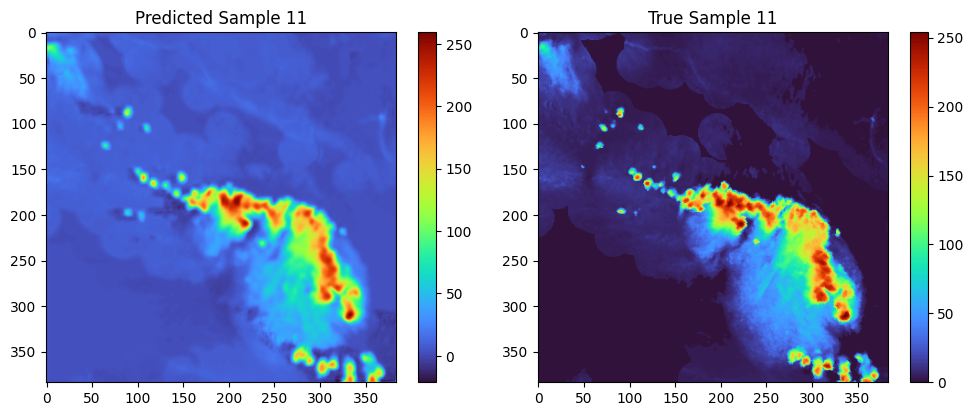

Observing the comparison images, the prediction results are extremely close to the true values. Additionally, the issue with the data range was resolved by introducing normalization, which supports the necessity of normalization for subsequent experiments.

However, when plotting the loss comparison between our implemented model and the baseline model, we found that the loss value of our model does not increase with the number of frames. Theoretically, using prediction results for subsequent predictions should lead to a noticeable accumulation of errors, but this was not observed in practice.

Upon reviewing the model's implementation process, we discovered that during sliding window predictions, each frame's prediction used the true value instead of the predicted value. This prevented the model's error from increasing with the number of frames and introduced some logical issues in the code that were difficult to resolve quickly.

**Consequently, we abandoned the implementation of this part(optimized model) and chose to reimplement a ConvLSTM-based model instead.**

## EnhancedVILPredictor: A ConvLSTM-Based Forecasting Model

This model is designed to predict multiple future frames (e.g., weather or radar frames) from past inputs using a **U-Net-like** encoder-decoder architecture combined with **ConvLSTM** cells. The primary goal is to capture both the **spatial** and **temporal** dependencies in the data.

---

### Model Overview

1. **Encoder**  
   - **ConvLSTMCell (encoder1)**: Takes in the initial input frames and produces spatiotemporal features.  
   - **Downsampling (down1)**: Reduces spatial dimensions to increase the receptive field.  
   - **ConvLSTMCell (encoder2)**: Further transforms the downsampled features, doubling the hidden dimension.  
   - **Downsampling (down2)**: Another spatial reduction layer.  
   - **Bottleneck (ConvLSTMCell)**: Processes the most compressed representation with a larger hidden size (hidden_dim * 4).

2. **Decoder**  
   - **Upsample (up1)**: Increases the spatial dimensions back to a larger size.  
   - **ConvLSTMCell (decoder1)**: Refines the upsampled features.  
   - **Upsample (up2)**: Restores the original input’s spatial size.  
   - **ConvLSTMCell (decoder2)**: Further refines features, reducing hidden dimension back to the initial size.  
   - **Final Convolution (final_conv)**: Outputs the desired number of frames (`out_frames`).

By combining downsampling and upsampling, the model captures large-scale spatial context while still preserving local details.

---

### How the Forward Pass Works

1. **Input Shape**  
   The input tensor `x` has dimensions:  
   \[
   (B, \text{Channels}, T, H, W)
   \]  
   where:  
   - \( B \) = Batch size  
   - \( \text{Channels} \) = Number of input channels (e.g., 1 for single-channel radar data)  
   - \( T \) = Number of time steps (previous frames)  
   - \( H, W \) = Spatial height and width

2. **Initialize Hidden States**  
   Each `ConvLSTMCell` needs a hidden state \((h, c)\). The model initializes these for:  
   - `encoder1` at full resolution \((H, W)\)  
   - `encoder2` at half resolution \((H/2, W/2)\)  
   - `bottleneck` at quarter resolution \((H/4, W/4)\)

3. **Temporal Encoding (Loop Over Time)**  
   For each time step \( t\_step \) in the input sequence:  
   - Extract the slice `x_t` (shape \((B, \text{Channels}, H, W)\)).  
   - Pass `x_t` and the previous hidden state \((h1, c1)\) to `encoder1`.  
   - Downsample the output (\( d1 \)) and feed it into `encoder2` with its hidden state \((h2, c2)\).  
   - Downsample the result (\( d2 \)) to pass into the bottleneck.

4. **Bottleneck**  
   After processing all input frames, the final feature map \( d2 \) is passed to the bottleneck `ConvLSTMCell` to capture high-level spatiotemporal patterns.

5. **Decoding and Upsampling**  
   - **Upsample** the bottleneck output (\( h_b \)) to half resolution, then process with `decoder1`.  
   - Upsample again to the original resolution, then process with `decoder2`.

6. **Final Convolution**  
   A 1x1 convolution (`final_conv`) produces the desired output channels (equal to `out_frames`). The model then adds a time dimension back (using `.unsqueeze(2)`) so the final output shape looks like:
   \[
   (B, \text{out\_frames}, 1, H, W).
   \]

---

### ConvLSTMCell Details

Each **ConvLSTMCell** is responsible for capturing **both** spatial features (via 2D convolution) and temporal dynamics (via LSTM gating).

### Why This Architecture?

1. **Spatiotemporal Modeling**:  
   The combination of **ConvLSTM** cells with down/upsampling lets the network handle both fine details and broad structures in sequential data.

2. **Multi-Frame Prediction**:  
   By setting `out_frames = 12`, the network learns to predict a sequence of 12 future frames based on past inputs, providing richer forecasting ability than single-frame outputs.

3. **Hierarchical Feature Extraction**:  
   Downsampling encodes higher-level abstractions, while upsampling recovers resolution for accurate final predictions.

4. **Flexibility**:  
   Hidden dimension (`hidden_dim`), number of output frames (`out_frames`), and input channels (`input_channels`) can be tweaked for various use cases (e.g., radar forecasting, video prediction, etc.).

---

**Summary**  
The **EnhancedVILPredictor** class builds upon standard ConvLSTM concepts, extending them with a U-Net-like encoder-decoder approach. This allows multi-frame predictions with strong spatiotemporal representations, making the model well-suited for tasks like **weather nowcasting**, **video frame prediction**, and similar spatiotemporal forecasting problems.


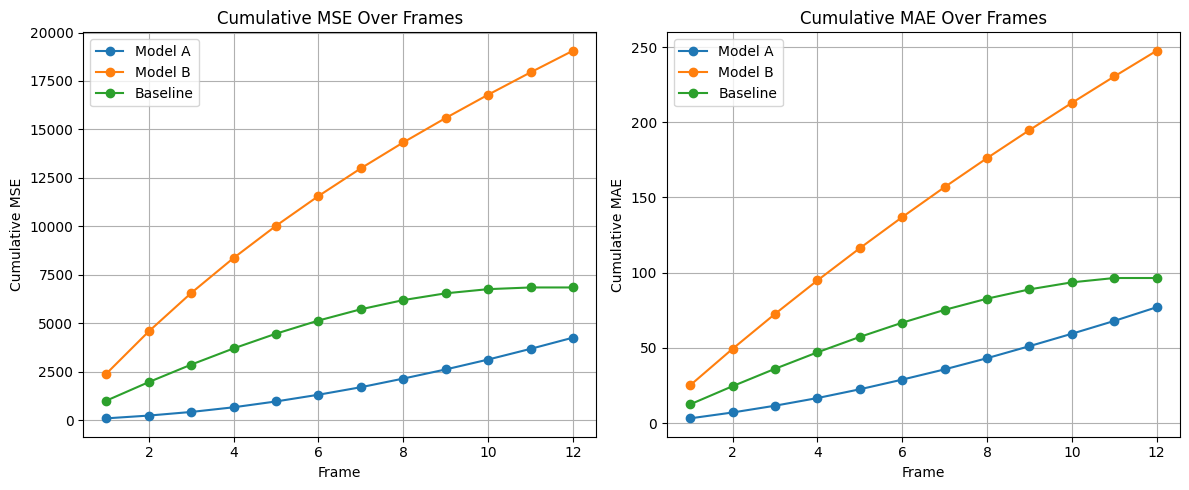